# Lane Segmentation with VGG16 as Encoder in UNet Architecture 🧶

## 1. Installation

In [82]:
!pip install pandas numpy matplotlib opencv-python tqdm tensorflow

  Using cached protobuf-5.29.5-cp38-abi3-manylinux2014_x86_64.whl.metadata (592 bytes)
  Using cached tensorboard-2.19.0-py3-none-any.whl.metadata (1.8 kB)
  Using cached keras-3.10.0-py3-none-any.whl.metadata (6.0 kB)
  Using cached tensorboard_data_server-0.7.2-py3-none-manylinux_2_31_x86_64.whl.metadata (1.1 kB)
Using cached protobuf-5.29.5-cp38-abi3-manylinux2014_x86_64.whl (319 kB)
Using cached tensorboard-2.19.0-py3-none-any.whl (5.5 MB)
Using cached tensorboard_data_server-0.7.2-py3-none-manylinux_2_31_x86_64.whl (6.6 MB)
Using cached keras-3.10.0-py3-none-any.whl (1.4 MB)
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.6.1
    Uninstalling tensorboard-data-server-0.6.1:
      Successfully uninstalled tensorboard-data-server-0.6.1
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.19.6
    Uninstalling protobuf-3.19.6:
      Successfully uninstalled protobuf-3.19.6╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

## 2. Import Libs/Modules

In [83]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plot
import cv2
import random
import shutil
from tqdm.auto import tqdm
import tensorflow as tf

## 3. Dataset Process

### 3.1. Define Directories 

In [84]:
IMAGE_FOLDER = '/home/legaca/16temmuz/dataset/images'
MASK_FOLDER = '/home/legaca/16temmuz/dataset/masks'

In [85]:
def create_directories_if_not_exist (dir_path):
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)
        print('Directory Created:', dir_path)
    else:
        print('Directory already exists:', dir_path)

In [86]:
create_directories_if_not_exist (IMAGE_FOLDER)
create_directories_if_not_exist (MASK_FOLDER)

Directory already exists: /home/legaca/16temmuz/dataset/images
Directory already exists: /home/legaca/16temmuz/dataset/masks


### 3.2. Process Clips

In [87]:
CLIPS_PATH = "/home/legaca/Downloads/archive/TUSimple/train_set/clips" # if you had a error about here, change the directory
# iterate through each directory
for clip_dir in os.listdir (CLIPS_PATH):
    clip_dir_path = os.path.join(CLIPS_PATH, clip_dir)
    print("Processing Clip:", clip_dir)
# iterate through each sub directory
    for frame_dir in os.listdir (clip_dir_path):
        frame_path = os.path.join(clip_dir_path, frame_dir, '20.jpg')
            # check if file is present
        if not os.path.isfile(frame_path):
            continue
# create new filename based on last 2 directory names
        temp = frame_path[:-7].split('/')[-2:] # frame_path - /kaggle/input/tusimple/TUSimple/t
        new_filename = f" {temp[0]}_{temp[1]}.jpg"
        new_file_path = os.path.join(IMAGE_FOLDER, new_filename)
# copy the file
        shutil.copy(frame_path, new_file_path)

Processing Clip: 0601
Processing Clip: 0313-2
Processing Clip: 0531
Processing Clip: 0313-1


In [88]:
print('Total Images in Dataset:', len(os.listdir (IMAGE_FOLDER)))

Total Images in Dataset: 3626


### 3.3. Read JSON files & Create Masks

In [89]:
# load the dataset json files */*/*
df1 = pd.read_json('/home/legaca/Downloads/archive/TUSimple/train_set/label_data_0313.json', lines=True)
df2 = pd.read_json('/home/legaca/Downloads/archive/TUSimple/train_set/label_data_0531.json', lines=True)
df3 = pd.read_json('/home/legaca/Downloads/archive/TUSimple/train_set/label_data_0601.json', lines=True)
# combine into single dataframe
df = pd.concat([df1, df2, df3])
df.head()

,lanes,h_samples,raw_file
0,"[[-2, -2, -2, -2, 632, 625, 617, 609, 601, 594...","[240, 250, 260, 270, 280, 290, 300, 310, 320, ...",clips/0313-1/6040/20.jpg
1,"[[-2, -2, -2, 658, 646, 635, 623, 612, 601, 58...","[240, 250, 260, 270, 280, 290, 300, 310, 320, ...",clips/0313-1/5320/20.jpg
2,"[[-2, 570, 554, 538, 522, 505, 489, 473, 456, ...","[240, 250, 260, 270, 280, 290, 300, 310, 320, ...",clips/0313-1/23700/20.jpg
3,"[[-2, -2, -2, -2, 555, 542, 530, 517, 505, 493...","[240, 250, 260, 270, 280, 290, 300, 310, 320, ...",clips/0313-1/51660/20.jpg
4,"[[-2, -2, -2, 522, 525, 528, 531, 534, 537, 53...","[240, 250, 260, 270, 280, 290, 300, 310, 320, ...",clips/0313-1/25680/20.jpg


In [90]:
def generate_lane_mask(row):
    # create a mask of all zeros
    mask = np.zeros((720, 1280, 1), dtype=np.uint8)
    h_samples = row.h_samples
    lanes = row.lanes
    raw_file = row.raw_file

    # create mask; lane=1, non-lane=0
    for lane in lanes:
        # exclude -2 datapoints
        h_samples_filtered = [y for x, y in zip(lane, h_samples) if x != -2]
        lane_filtered = [x for x in lane if x != -2]
        lane_points = np.array(list(zip(lane_filtered, h_samples_filtered)), dtype=np.int32)

        if len(lane_points) >= 2:
            cv2.polylines(mask, [lane_points], isClosed=False, color=(255, 255, 255), thickness=15)

    # generate mask filename
    temp = raw_file[:-7].split('/')[-2:]
    mask_filename = f"{temp[0]}_{temp[1]}.jpg"
    mask_filename_path = os.path.join(MASK_FOLDER, mask_filename)

    # write the mask image
    cv2.imwrite(mask_filename_path, mask)


In [91]:
for index, row in tqdm(df.iterrows(), total=len(df)):
    generate_lane_mask(row)
# masks are created

  0%|          | 0/3626 [00:00<?, ?it/s]

In [92]:
print("Total Mask in Dataset:", len(os.listdir(MASK_FOLDER)))

Total Mask in Dataset: 3626


### 3.4. Visualize Images

In [93]:
def visualize_image(image_name):
    image_path = os.path.join(IMAGE_FOLDER, image_name)
    mask_path = os.path.join(MASK_FOLDER, image_name)

    if not os.path.exists(image_path):
        print(f"Image file bulunamadı: {image_path}")
        return
    if not os.path.exists(mask_path):
        print(f"Mask file bulunamadı: {mask_path}")
        return

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    plt.figure(figsize=(20, 8))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title('Road Image')

    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap='gray')
    plt.title('Ground Truth Mask')
    plt.show()


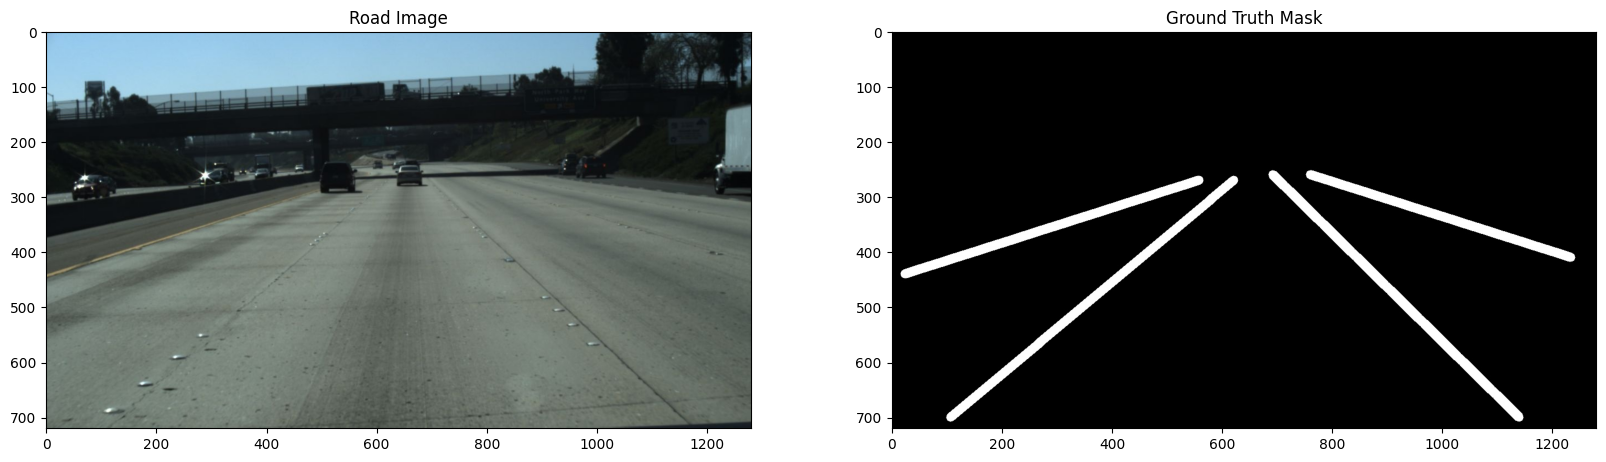

In [100]:
import matplotlib.pyplot as plt

image_name = '0313-1_8440.jpg'
visualize_image(image_name)


In [98]:
print(os.listdir(IMAGE_FOLDER)[:20])

['0313-1_8440.jpg', '0313-2_15360.jpg', '0601_1494453225724484936.jpg', '0313-1_16460.jpg', '0313-2_8520.jpg', '0313-1_5460.jpg', '0313-1_10280.jpg', '0313-2_26340.jpg', '0313-1_46740.jpg', '0313-1_8400.jpg', '0313-2_375.jpg', '0313-2_405.jpg', '0531_1492638227112984770.jpg', '0313-1_13680.jpg', '0601_1495058823515900521.jpg', '0313-2_61140.jpg', '0601_1494453859446867209.jpg', '0313-1_43500.jpg', '0313-2_13980.jpg', '0313-2_36920.jpg']


In [97]:
import os

def clean_filenames(folder):
    for filename in os.listdir(folder):
        clean_name = filename.strip()
        if clean_name != filename:
            os.rename(
                os.path.join(folder, filename),
                os.path.join(folder, clean_name)
            )

clean_filenames(IMAGE_FOLDER)
clean_filenames(MASK_FOLDER)

## 4. Process data for Train and Test

### 4.1. Define directories

In [101]:
train_image_folder = '/home/legaca/16temmuz/dataset/train/images'
train_mask_folder = '/home/legaca/16temmuz/dataset/train/masks'
test_image_folder = '/home/legaca/16temmuz/dataset/test/images'
test_mask_folder = '/home/legaca/16temmuz/dataset/test/masks'

In [102]:
for folder_path in [train_image_folder, test_image_folder, train_mask_folder, test_mask_folder]:
    create_directories_if_not_exist(folder_path)

Directory Created: /home/legaca/16temmuz/dataset/train/images
Directory Created: /home/legaca/16temmuz/dataset/test/images
Directory Created: /home/legaca/16temmuz/dataset/train/masks
Directory Created: /home/legaca/16temmuz/dataset/test/masks


In [103]:
!pip install scikit-learn

### 4.2. Split Dataset --> Test & Train

In [104]:
from sklearn.model_selection import train_test_split
images = [file for file in os.listdir (IMAGE_FOLDER) if file.endswith('.jpg')]
masks = [file for file in os.listdir (MASK_FOLDER) if file.endswith('.jpg')]
#split for train and test
train_images, test_images = train_test_split(images, test_size=0.1, random_state=42)

In [105]:
len(train_images), len(test_images)

(3263, 363)

In [106]:
#move files to the corresponding folders
for file in train_images:
#nove the image and mask
    source = os.path.join(IMAGE_FOLDER, file)
    destination = os.path.join(train_image_folder, file)
    shutil.move(source, destination)
    
    source = os.path.join(MASK_FOLDER, file)
    destination = os.path.join(train_mask_folder, file)
    shutil.move(source, destination)
for file in test_images:
#move the image and mask
    source = os.path.join(IMAGE_FOLDER, file)
    destination = os.path.join(test_image_folder, file)
    shutil.move(source, destination)
    
    source = os.path.join(MASK_FOLDER, file)
    destination = os.path.join(test_mask_folder, file)
    shutil.move (source, destination)

In [107]:
def load_image(image_path, mask_path):
    size = [224, 224]
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, size)
    image = image/255.0 #normalize to [0, 1]

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_jpeg(mask, channels=1)
    mask = tf.image.resize(mask, size)
    mask = mask/255.0 #normalize to [0, 1]

    return image, mask

def dataset_from_folder(image_folder, mask_folder):
    image_files = sorted([os.path.join(image_folder, file) 
                          for file in os.listdir(image_folder) if file.endswith('.jpg')])
    mask_files = sorted([os.path.join(mask_folder, file) 
                         for file in os.listdir(mask_folder) if file.endswith('.jpg')])
    dataset = tf.data.Dataset.from_tensor_slices((image_files, mask_files))
    dataset = dataset.map(lambda image_path, mask_path: load_image(image_path, mask_path))
    return dataset

In [108]:
train_dataset = dataset_from_folder(train_image_folder, train_mask_folder)
test_dataset = dataset_from_folder(test_image_folder, test_mask_folder)

### 4.3. Some Parameters

In [109]:
BATCH_SIZE = 8
BUFFER_SIZE = 1000
#optimize for performance improvement
train_dataset = train_dataset.cache().shuffle(BUFFER_SIZE).repeat().batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

### 4.4. Display Samples

In [110]:
def display_sample(image_list):
    plt.figure(figsize=(10, 10))

    titles = ['Image', 'True Mask', 'Predicted Mask']

    for i in range(len(image_list)):
        plt.subplot(1, len(image_list), i+1)
        plt.title(titles[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(image_list[i]))
        plt.axis('off')
    plt.show()

2025-07-17 11:28:36.298219: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


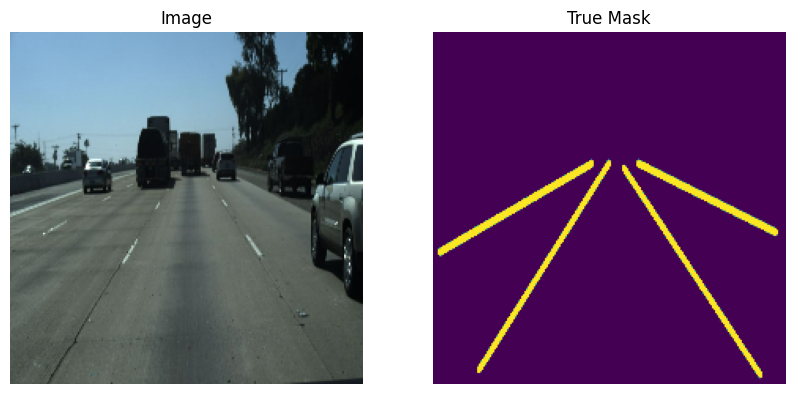

2025-07-17 11:28:36.389185: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [111]:
for image, mask in train_dataset.take(1):
    display_sample([image[0], mask[0]])

## 5. Model Architecture :)

In [112]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input, Conv2D, Dropout, BatchNormalization, UpSampling2D, Concatenate
from tensorflow.keras.models import Model

def VGG16_UNet(input_shape=(224, 224, 3)):
    '''U-Net architecture with VGG16 encoder and decoder with skip connections'''
    def Conv2DReluBatchNorm(n_filters, kernel_size, strides, inputs):
        x = Conv2D(n_filters, (1,1), strides=1, padding='same',
                   kernel_initializer='glorot_normal', activation='elu')(inputs)
        x = Conv2D(n_filters, kernel_size, strides=strides, padding='same',
                   kernel_initializer='glorot_normal', activation='elu')(x)
        x = BatchNormalization()(x)
        x = Dropout(rate=0.25)(x, training=True)
        return x

    vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    for layer in vgg16.layers:
        layer.trainable = True

    inputs = vgg16.input
    layer1 = vgg16.get_layer('block1_conv2').output
    layer2 = vgg16.get_layer('block2_conv2').output
    layer3 = vgg16.get_layer('block3_conv3').output
    layer4 = vgg16.get_layer('block4_conv3').output
    layer5 = vgg16.get_layer('block5_conv3').output

    merge6 = Concatenate(axis=-1)([UpSampling2D(size=(2,2))(layer5), layer4])
    layer6 = Conv2DReluBatchNorm(512, (3, 3), (1,1), merge6)

    merge7 = Concatenate(axis=-1)([UpSampling2D(size=(2,2))(layer6), layer3])
    layer7 = Conv2DReluBatchNorm(256, (3, 3), (1,1), merge7)

    merge8 = Concatenate(axis=-1)([UpSampling2D(size=(2,2))(layer7), layer2])
    layer8 = Conv2DReluBatchNorm(128, (3, 3), (1,1), merge8)

    merge9 = Concatenate(axis=-1)([UpSampling2D(size=(2,2))(layer8), layer1])
    layer9 = Conv2DReluBatchNorm(64, (3, 3), (1,1), merge9)

    output = Conv2D(1, (1, 1), strides=(1,1), activation='sigmoid', name='output')(layer9)

    return Model(inputs=inputs, outputs=output)

# Modeli oluştur
model = VGG16_UNet(input_shape=(224,224,3))
model.summary()


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 224, 224,  │      1,792 │ input_layer_4[0]… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 224, 224,  │     36,928 │ block1_conv1[0][… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool         │ (None, 112, 112,  │          0 │ block1_conv2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, 112, 112,  │     73,856 │ block1_pool[0][0] │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv2        │ (None, 112, 112,  │    147,584 │ block2_conv1[0][… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 56, 56,    │          0 │ block2_conv2[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv1        │ (None, 56, 56,    │    295,168 │ block2_pool[0][0] │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv2        │ (None, 56, 56,    │    590,080 │ block3_conv1[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv3        │ (None, 56, 56,    │    590,080 │ block3_conv2[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_pool         │ (None, 28, 28,    │          0 │ block3_conv3[0][… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv1        │ (None, 28, 28,    │  1,180,160 │ block3_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv2        │ (None, 28, 28,    │  2,359,808 │ block4_conv1[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv3        │ (None, 28, 28,    │  2,359,808 │ block4_conv2[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_pool         │ (None, 14, 14,    │          0 │ block4_conv3[0][… │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv1        │ (None, 14, 14,    │  2,359,808 │ block4_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv2        │ (None, 14, 14,    │  2,359,808 │ block5_conv1[0][

 Total params: 18,636,289 (71.09 MB)

 Trainable params: 18,634,369 (71.08 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [ ]:
## 6. Define Some Metrics

In [113]:
import tensorflow
from  tensorflow.keras import backend as K

def dice_coefficient(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred[:, :, :, 0])  # sadece birinci kanalı kullan
    intersection = K.sum(y_true_f * y_pred_f)
    smooth = 1.0
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# Dice Loss
def dice_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)

# Recall (Duyarlılık)
def recall_smooth(y_true, y_pred):
    y_pred_f = K.flatten(y_pred[:, :, :, 0])  # kanal seç
    y_true_f = K.flatten(y_true)
    intersection = K.sum(y_true_f * y_pred_f)
    return intersection / (K.sum(y_true_f) + K.epsilon())

# Precision (Kesinlik)
def precision_smooth(y_true, y_pred):
    y_pred_f = K.flatten(y_pred[:, :, :, 0])  # kanal seç
    y_true_f = K.flatten(y_true)
    intersection = K.sum(y_true_f * y_pred_f)
    return intersection / (K.sum(y_pred_f) + K.epsilon())

# Accuracy (Doğruluk)
def accuracy(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.round(K.flatten(y_pred[:, :, :, 0]))  # 0.5 üzeri 1, altı 0

    true_positives = K.sum(K.round(K.clip(y_true_f * y_pred_f, 0, 1)))
    true_negatives = K.sum(K.round(K.clip((1 - y_true_f) * (1 - y_pred_f), 0, 1)))
    total_pixels = K.cast(tf.size(y_true_f), K.floatx())

    accuracy_value = (true_positives + true_negatives) / total_pixels
    return accuracy_value

In [114]:
model.compile(optimizer = 'adam', loss=dice_loss, metrics=[dice_coefficient, precision_smooth, recall_smooth, accuracy])
print("Number of parameters: ", model.count_params())

Number of parameters:  18636289


In [115]:
pip install pydot

Note: you may need to restart the kernel to use updated packages.


In [52]:
import pydot
print("pydot OK")

pydot OK


## 7. View Architecture with pylot

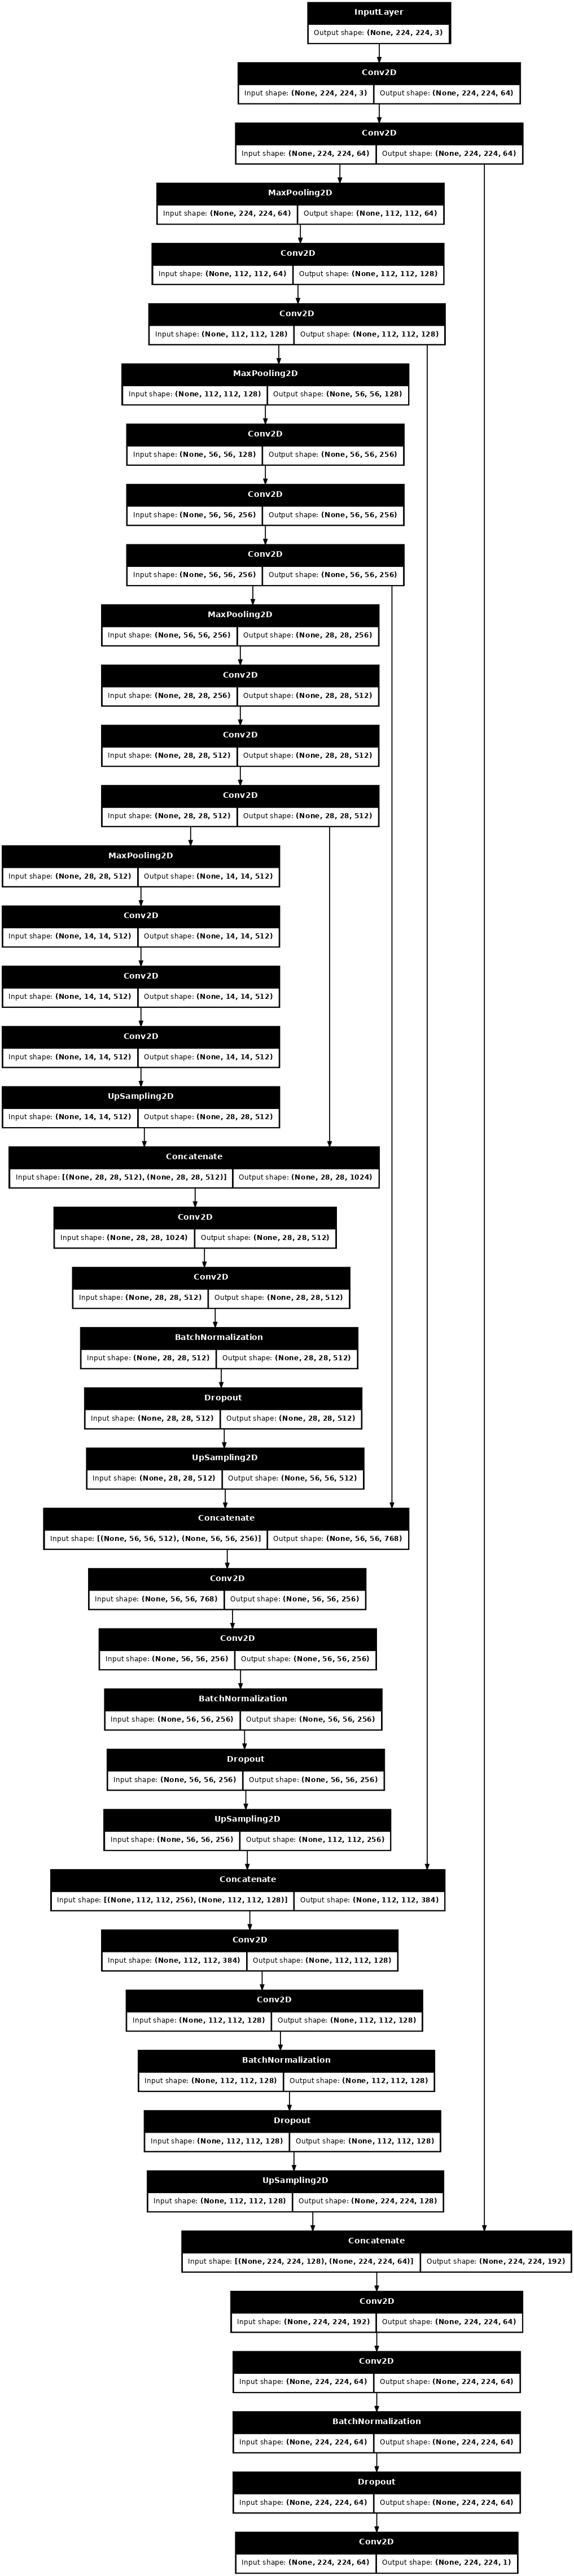

In [116]:
from tensorflow.keras.utils import plot_model
tf.keras.utils.plot_model(model, show_shapes=True, expand_nested=False, dpi=64)

## 8. View Predictions

In [117]:
def create_mask(pred_mask):
    pred_mask = tf.math.round(pred_mask)
    return pred_mask

def show_predictions(dataset=None, num=1):
    if dataset:
        for images, masks in dataset.take(num):
            pred_mask = model.predict(images)
            pred_mask = create_mask(pred_mask[0])
            display_sample([images[0], masks[0], pred_mask])


2025-07-17 11:29:18.069901: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 907ms/step


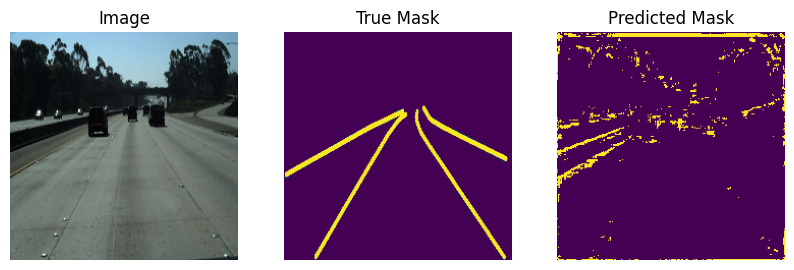

2025-07-17 11:29:19.219750: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [118]:
show_predictions(train_dataset)

In [119]:
print(model.summary())

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 224, 224,  │      1,792 │ input_layer_4[0]… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 224, 224,  │     36,928 │ block1_conv1[0][… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool         │ (None, 112, 112,  │          0 │ block1_conv2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, 112, 112,  │     73,856 │ block1_pool[0][0] │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv2        │ (None, 112, 112,  │    147,584 │ block2_conv1[0][… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 56, 56,    │          0 │ block2_conv2[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv1        │ (None, 56, 56,    │    295,168 │ block2_pool[0][0] │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv2        │ (None, 56, 56,    │    590,080 │ block3_conv1[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv3        │ (None, 56, 56,    │    590,080 │ block3_conv2[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_pool         │ (None, 28, 28,    │          0 │ block3_conv3[0][… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv1        │ (None, 28, 28,    │  1,180,160 │ block3_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv2        │ (None, 28, 28,    │  2,359,808 │ block4_conv1[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv3        │ (None, 28, 28,    │  2,359,808 │ block4_conv2[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_pool         │ (None, 14, 14,    │          0 │ block4_conv3[0][… │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv1        │ (None, 14, 14,    │  2,359,808 │ block4_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv2        │ (None, 14, 14,    │  2,359,808 │ block5_conv1[0][

 Total params: 18,636,289 (71.09 MB)

 Trainable params: 18,634,369 (71.08 MB)

 Non-trainable params: 1,920 (7.50 KB)

None


## 9. CallBack, parameters etc.

In [120]:
from tensorflow.keras import callbacks
import datetime
import os

class DisplayCallback(callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        show_predictions(test_dataset, 1)
        print(f'Sample Prediction after epoch {epoch}')

logdir = os.path.join('logs', datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

callback_list = [
    DisplayCallback(),
    callbacks.TensorBoard(log_dir=logdir, histogram_freq=1),
    callbacks.EarlyStopping(patience=5, verbose=1),
    callbacks.ModelCheckpoint('best_model.keras', verbose=1, save_best_only=True)
]

In [132]:
EPOCHS=10
steps_per_epoch = len(os.listdir(train_image_folder))// BATCH_SIZE
validation_steps = len(os.listdir(test_image_folder))// BATCH_SIZE

In [135]:
'''from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
callbacks = [
    EarlyStopping(patience=3, restore_best_weights=True),
    ModelCheckpoint('best_model.h5', save_best_only=True)
]'''

## 10.Train

In [136]:
from tensorflow.keras.callbacks import Callback

history = model.fit(
train_dataset,
validation_data = test_dataset,
epochs = EPOCHS,
steps_per_epoch = steps_per_epoch,
validation_steps = validation_steps,
callbacks = callbacks
)

Epoch 1/10


2025-07-17 11:36:19.898772: E tensorflow/core/util/util.cc:131] oneDNN supports DT_INT32 only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


407/407 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9093 - dice_coefficient: 0.4773 - loss: 0.5227 - precision_smooth: 0.3963 - recall_smooth: 0.7237

407/407 ━━━━━━━━━━━━━━━━━━━━ 1069s 3s/step - accuracy: 0.9094 - dice_coefficient: 0.4777 - loss: 0.5223 - precision_smooth: 0.3967 - recall_smooth: 0.7237 - val_accuracy: 0.9739 - val_dice_coefficient: 0.7123 - val_loss: 0.2877 - val_precision_smooth: 0.6705 - val_recall_smooth: 0.7614
Epoch 2/10
407/407 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9754 - dice_coefficient: 0.7230 - loss: 0.2770 - precision_smooth: 0.6934 - recall_smooth: 0.7564

407/407 ━━━━━━━━━━━━━━━━━━━━ 1061s 3s/step - accuracy: 0.9754 - dice_coefficient: 0.7230 - loss: 0.2770 - precision_smooth: 0.6934 - recall_smooth: 0.7564 - val_accuracy: 0.9775 - val_dice_coefficient: 0.7451 - val_loss: 0.2549 - val_precision_smooth: 0.7167 - val_recall_smooth: 0.7779
Epoch 3/10
407/407 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9776 - dice_coefficient: 0.7471 - loss: 0.2529 - precision_smooth: 0.7222 - recall_smooth: 0.7747

407/407 ━━━━━━━━━━━━━━━━━━━━ 1054s 3s/step - accuracy: 0.9776 - dice_coefficient: 0.7471 - loss: 0.2529 - precision_smooth: 0.7222 - recall_smooth: 0.7747 - val_accuracy: 0.9779 - val_dice_coefficient: 0.7509 - val_loss: 0.2491 - val_precision_smooth: 0.7214 - val_recall_smooth: 0.7843
Epoch 4/10
407/407 ━━━━━━━━━━━━━━━━━━━━ 1062s 3s/step - accuracy: 0.9785 - dice_coefficient: 0.7585 - loss: 0.2415 - precision_smooth: 0.7307 - recall_smooth: 0.7893 - val_accuracy: 0.9771 - val_dice_coefficient: 0.7450 - val_loss: 0.2550 - val_precision_smooth: 0.7062 - val_recall_smooth: 0.7896
Epoch 5/10
407/407 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9794 - dice_coefficient: 0.7667 - loss: 0.2333 - precision_smooth: 0.7377 - recall_smooth: 0.7986

407/407 ━━━━━━━━━━━━━━━━━━━━ 1068s 3s/step - accuracy: 0.9794 - dice_coefficient: 0.7667 - loss: 0.2333 - precision_smooth: 0.7377 - recall_smooth: 0.7986 - val_accuracy: 0.9792 - val_dice_coefficient: 0.7582 - val_loss: 0.2418 - val_precision_smooth: 0.7463 - val_recall_smooth: 0.7722
Epoch 6/10
407/407 ━━━━━━━━━━━━━━━━━━━━ 1080s 3s/step - accuracy: 0.9797 - dice_coefficient: 0.7711 - loss: 0.2289 - precision_smooth: 0.7433 - recall_smooth: 0.8015 - val_accuracy: 0.9785 - val_dice_coefficient: 0.7577 - val_loss: 0.2423 - val_precision_smooth: 0.7276 - val_recall_smooth: 0.7914
Epoch 7/10
407/407 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9802 - dice_coefficient: 0.7759 - loss: 0.2241 - precision_smooth: 0.7478 - recall_smooth: 0.8067

407/407 ━━━━━━━━━━━━━━━━━━━━ 1089s 3s/step - accuracy: 0.9802 - dice_coefficient: 0.7759 - loss: 0.2241 - precision_smooth: 0.7478 - recall_smooth: 0.8067 - val_accuracy: 0.9788 - val_dice_coefficient: 0.7627 - val_loss: 0.2373 - val_precision_smooth: 0.7261 - val_recall_smooth: 0.8045
Epoch 8/10
407/407 ━━━━━━━━━━━━━━━━━━━━ 1112s 3s/step - accuracy: 0.9805 - dice_coefficient: 0.7804 - loss: 0.2196 - precision_smooth: 0.7522 - recall_smooth: 0.8113 - val_accuracy: 0.9789 - val_dice_coefficient: 0.7623 - val_loss: 0.2377 - val_precision_smooth: 0.7318 - val_recall_smooth: 0.7967
Epoch 9/10
407/407 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9809 - dice_coefficient: 0.7840 - loss: 0.2160 - precision_smooth: 0.7571 - recall_smooth: 0.8134

407/407 ━━━━━━━━━━━━━━━━━━━━ 1084s 3s/step - accuracy: 0.9809 - dice_coefficient: 0.7840 - loss: 0.2160 - precision_smooth: 0.7571 - recall_smooth: 0.8134 - val_accuracy: 0.9798 - val_dice_coefficient: 0.7646 - val_loss: 0.2354 - val_precision_smooth: 0.7564 - val_recall_smooth: 0.7740
Epoch 10/10
407/407 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9813 - dice_coefficient: 0.7877 - loss: 0.2123 - precision_smooth: 0.7621 - recall_smooth: 0.8156

407/407 ━━━━━━━━━━━━━━━━━━━━ 1061s 3s/step - accuracy: 0.9813 - dice_coefficient: 0.7877 - loss: 0.2123 - precision_smooth: 0.7621 - recall_smooth: 0.8156 - val_accuracy: 0.9788 - val_dice_coefficient: 0.7651 - val_loss: 0.2349 - val_precision_smooth: 0.7244 - val_recall_smooth: 0.8117


In [61]:
pip install tensorflow-gpu # sıkıntılar vR...


  Using cached keras-2.11.0-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached protobuf-3.19.6-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (787 bytes)
  Using cached tensorboard-2.11.2-py3-none-any.whl.metadata (1.9 kB)
  Using cached tensorboard_data_server-0.6.1-py3-none-manylinux2010_x86_64.whl.metadata (1.1 kB)
Using cached keras-2.11.0-py2.py3-none-any.whl (1.7 MB)
Using cached protobuf-3.19.6-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.1 MB)
Using cached tensorboard-2.11.2-py3-none-any.whl (6.0 MB)
Using cached tensorboard_data_server-0.6.1-py3-none-manylinux2010_x86_64.whl (4.9 MB)
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.7.2
    Uninstalling tensorboard-data-server-0.7.2:
      Successfully uninstalled tensorboard-data-server-0.7.2
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully unin

In [62]:
'''import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=callbacks_list
)'''


Num GPUs Available:  0


NameError: name 'callbacks_list' is not defined

## 11. Plot train and val accuracy/loss

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy' ])
plt.plot(history.history['val_accuracy' ])
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend ([ 'Train', 'Test'], loc='upper left')
# plot train and val loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend ([ 'Train', 'Test'], loc='upper left')
plt.tight_layout()
plt.show()

## 12. Load model

In [141]:
best_model = tf.keras.models.load_model('/home/legaca/best_model.h5',
custom_objects={'dice_loss': dice_loss,
'dice_coefficient': dice_coefficient,
'precision_smooth': precision_smooth,
' recall_smooth': recall_smooth,
'accuracy': accuracy
})
# best_model.compile(optimizer='adam', loss-dice_loss, metrics=[dice_coefficient, precision_smooth, recall_smooth, accuracy])
# best_model.summary()

## 13. Test Model

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 700ms/step


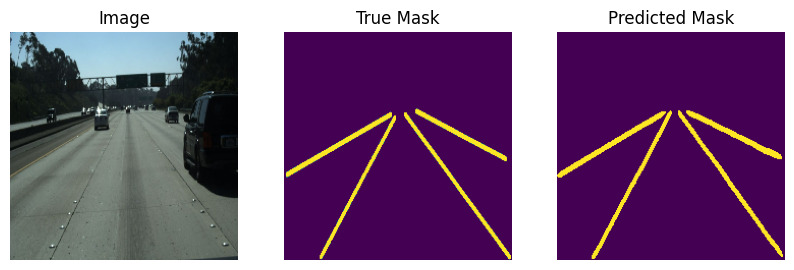

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 694ms/step


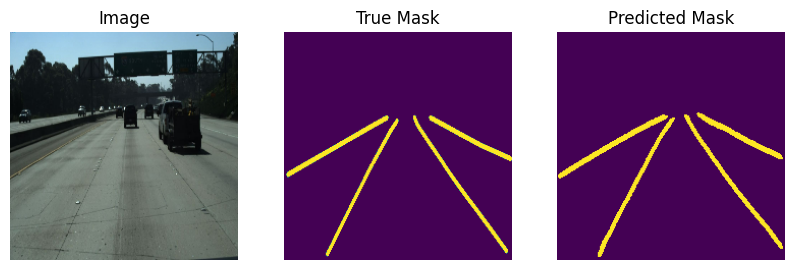

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 702ms/step


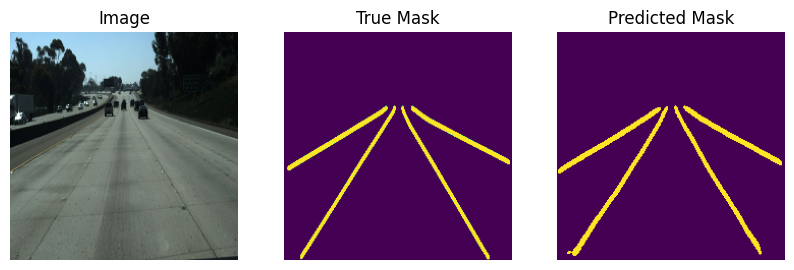

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 693ms/step


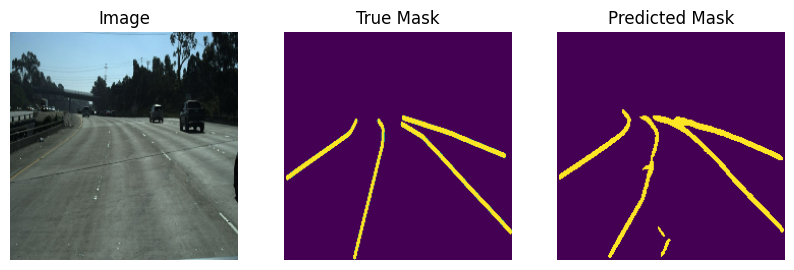

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 694ms/step


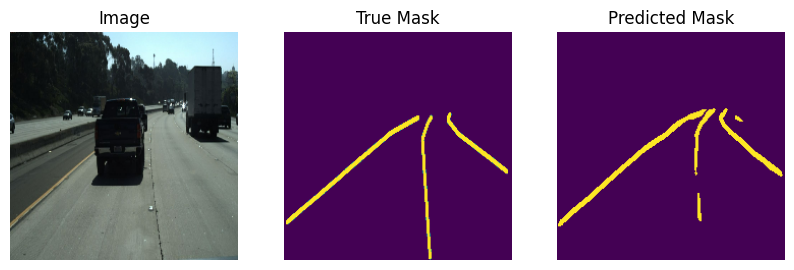

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 697ms/step


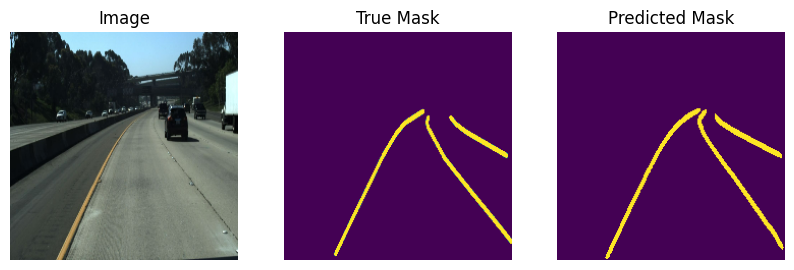

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 696ms/step


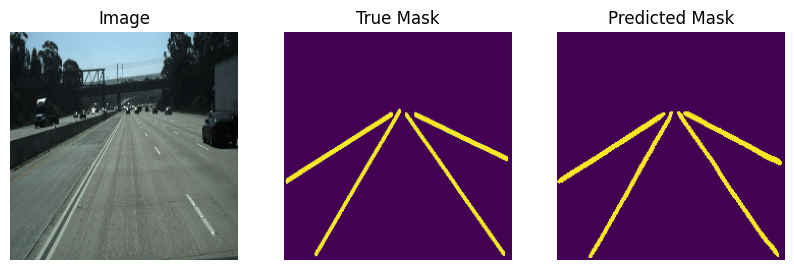

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 683ms/step


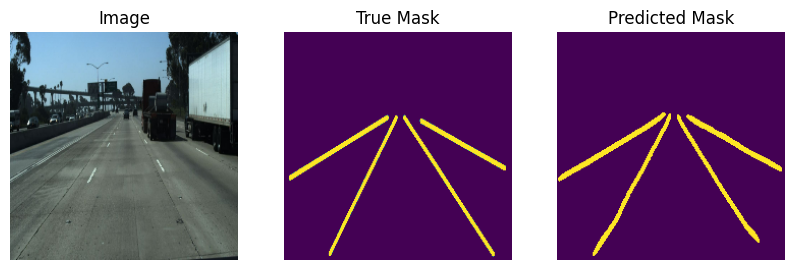

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 691ms/step


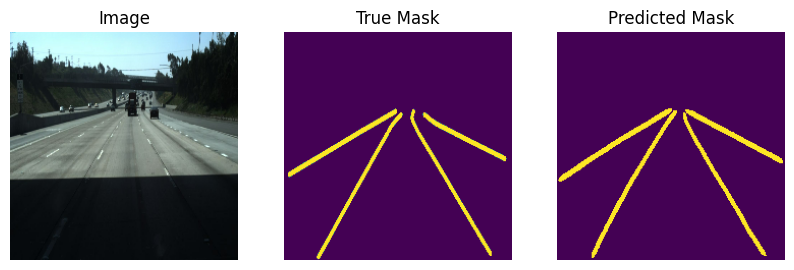

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 690ms/step


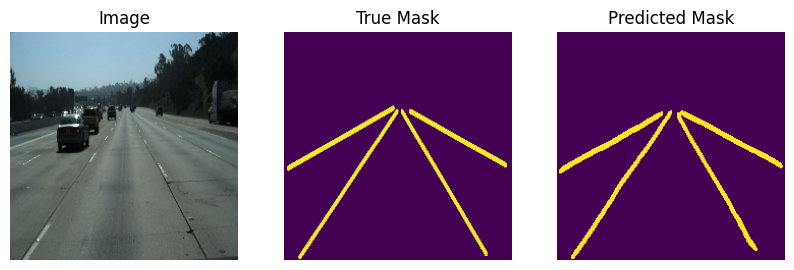

In [143]:
show_predictions(test_dataset, 10)